#### Import libraries.

In [1]:

import time
import pandas as pd
import numpy as np
from collections import Counter
from keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.layers import Conv1D, Dense, Flatten, Input, MaxPooling1D
from keras.optimizers import AdamW
from sklearn.metrics import classification_report
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import PowerTransformer
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE
from matplotlib import pyplot as plt


#### Load the dataset.

In [2]:

df = pd.read_csv("../dataset/original-noneeg-dataset.csv", sep="|", dtype = {"hr": "float64", "label": "int8"})


#### Display the dataset size.

In [3]:
df.shape

(41992, 2)

#### Define a helper function to convert the set data to the required format to perform the undersampling.

In [4]:

number_of_steps = 30

def build_time_window_structure(df):
    # Splits the dataset into "time windows" to be used as a time series list.
    # The function groups each 30 dataset records (CSV lines) into one record.
    # Each record contains 30 steps and each step contains 1 feature value.
    # Parameters:
    #    df: Dataframe to be splitted.
    # Return:
    #    First list contains all time windows.
    #    Second list contains all target values.
    print("\nStarting build_time_window_structure function.")
    initial_line_number = 0
    first_feat_index = 0
    last_feat_index = 1
    X_array = []
    y_array = []
    while initial_line_number < len(df["label"]):
        target_value = df["label"][initial_line_number]
        sub_matrix = df.iloc[initial_line_number : (initial_line_number + number_of_steps), first_feat_index : last_feat_index]
        sub_matrix_values = sub_matrix.values
        new_line = sub_matrix_values.flatten()
        size_diff = number_of_steps - len(new_line)
        if size_diff > 0:
            last_value = new_line[len(new_line) - 1]
            new_line = np.append(new_line, [last_value] * size_diff)
        X_array.append(new_line)
        y_array.append(target_value)
        initial_line_number += number_of_steps
    print("Quantity of samples (features) => ", len(X_array))
    print("Quantity os samples (labels) => ", len(y_array))
    print("Finishing build_time_window_structure function.")
    return X_array, y_array


#### Define a function to performe SMOTE to balance the dataset.

In [5]:

def apply_smote(X_array, y_array, apply_resample = False, quantity_of_resample = 0):
    # Apply SMOTE to balance the dataset and resample for data augmentation.
    # Parameters:
    #    X_array (np.array): array of features values.
    #    y_array (np.array): array of target values.
    #    apply_resample (boolean): resample will be performe if True.
    #    quantity_of_resample (int): number of samples generated by resample.
    # Return:
    #    X_oversampled (np.array): array of features values.
    #    y_oversampled (np.array): array of target values.
    print("\nGenerating upsampling using SMOTE...")
    smote = SMOTE(sampling_strategy = "auto", k_neighbors = 5, random_state = 42)
    X_array_res, y_array_res = smote.fit_resample(X_array, y_array)
    if apply_resample is True:
        X_oversampled, y_oversampled = resample(X_array_res,
                                                y_array_res,
                                                replace = True,
                                                n_samples = quantity_of_resample,
                                                stratify = y_array_res,
                                                random_state = 42)
    else:
        X_oversampled, y_oversampled = X_array_res, y_array_res
    print("{} samples after upsampling.".format(len(y_oversampled)))
    print(f"Class distribution for training after upsampling: {Counter(y_oversampled)}")
    print("Finishing upsampling.\n")
    return X_oversampled, y_oversampled


#### Define a function to train a CNN model.

In [6]:

number_of_features = 1

# Define the number of folds (10 k-Fold).
skf = StratifiedKFold(n_splits = 10, shuffle = True, random_state = 42)
# Normalize data using PowerTransformer method.
pt = PowerTransformer()
es = EarlyStopping(monitor = "val_loss", mode = "min", verbose = 1, patience = 30, restore_best_weights = True)

def train_cnn_model(cnn_model, X_arr, y_arr, apply_resample = False, quantity_of_resample = 0):
    # Train a CNN model.
    # Parameters:
    #    cnn_model (Sequential): model to be trained.
    #    X_arr (np.array): array of features values.
    #    y_arr (np.array): array of target values.
    #    apply_resample (boolean): resample will be performe if True.
    #    quantity_of_resample (int): number of samples generated by resample.
    # Returns:
    #    history (History object): history of training metrics.
    train_accuracy_by_fold = []
    test_accuracy_by_fold = []
    history_by_fold = []
    y_predclass_for_report = []
    y_testclass_for_report = []
    fold_number = 1
    start_time = time.time()
    print("\nStarting training...")
    for train_index, test_index in skf.split(X_arr, y_arr):
        print("\nTraining fold {}".format(fold_number))
        X_oversampled, y_oversampled = apply_smote(X_arr[train_index], y_arr[train_index],
                                                   apply_resample, quantity_of_resample)
        X_train_scaled = pt.fit_transform(X_oversampled)
        X_test_scaled = pt.transform(X_arr[test_index])
        # Reshape the structure data to be compatible with pattern [samples, timesteps, features].
        X_train_reshaped = X_train_scaled.reshape((X_train_scaled.shape[0], number_of_steps, number_of_features))
        X_test_reshaped = X_test_scaled.reshape((X_test_scaled.shape[0], number_of_steps, number_of_features))
        history = cnn_model.fit(X_train_reshaped, y_oversampled, validation_split = 0.01,
                                epochs = 300, batch_size = 32, verbose = 1, callbacks = [es])
        _, train_accuracy = cnn_model.evaluate(X_train_reshaped, y_oversampled, verbose = 0)
        _, test_accuracy = cnn_model.evaluate(X_test_reshaped, y_arr[test_index], verbose = 0)
        train_accuracy_by_fold.append(train_accuracy)
        test_accuracy_by_fold.append(test_accuracy)
        history_by_fold.append(history)
        y_predclass_for_report.extend(np.argmax(cnn_model.predict(X_test_reshaped), axis = 1))
        y_testclass_for_report.extend(y_arr[test_index])
        fold_number += 1
    elapsed_seconds = time.time() - start_time
    print("\nTime taken for training: ", time.strftime("%H:%M:%S", time.gmtime(elapsed_seconds)))
    print("\n")
    # Show metrics.
    for i in range(len(history_by_fold)):
        print("Fold {} - Train Accuracy {:.4f} - Test Accuracy {:.4f}".format((i + 1),
              train_accuracy_by_fold[i], test_accuracy_by_fold[i]))
    print("\nMean Train Accuracy: {:.4f} ".format(np.mean(train_accuracy_by_fold)))
    print("Mean Test Accuracy: {:.4f} ".format(np.mean(test_accuracy_by_fold)))
    print("\nEvaluate other metrics:")
    print(classification_report(y_testclass_for_report, y_predclass_for_report, zero_division = 0))
    return history_by_fold


#### Build "time window" structure.

In [7]:

X_list, y_list = build_time_window_structure(df)
X_arr = np.array(X_list)
y_arr = np.array(y_list)



Starting build_time_window_structure function.
Quantity of samples (features) =>  1400
Quantity os samples (labels) =>  1400
Finishing build_time_window_structure function.


#### Train a Convolutional Neural Network model and evaluate the metrics.
- Layer architecture => Conv1D (64) + Conv1D (32) + Conv1D (16) + MaxPooling1D + Flatten + Dense (32) + Dense (4)

In [8]:

def create_baseline():
    act_function = "relu"
    kernel_init = "he_uniform"
    model = Sequential()
    model.add(Input(shape = (number_of_steps, number_of_features)))
    model.add(Conv1D(filters = 64, kernel_size = 3, activation = act_function,
                     kernel_initializer = kernel_init))
    model.add(Conv1D(filters = 32, kernel_size = 3, activation = act_function,
                     kernel_initializer = kernel_init))
    model.add(Conv1D(filters = 16, kernel_size = 3, activation = act_function,
                     kernel_initializer = kernel_init))
    model.add(MaxPooling1D(pool_size = 2))
    model.add(Flatten())
    model.add(Dense(32, activation = act_function, kernel_initializer = kernel_init))
    model.add(Dense(4, activation = 'softmax'))
    op = AdamW(learning_rate = 0.001)
    model.compile(loss = "sparse_categorical_crossentropy", optimizer = op, metrics = ["accuracy"])
    model.summary()
    return model

# Train the CNN model and evaluate it.
model = create_baseline()
history_by_fold = train_cnn_model(model, X_arr, y_arr)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 28, 64)         │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 26, 32)         │         6,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 24, 16)         │         1,552 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 12, 16)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 192)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         6,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           132 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,292 (55.83 KB)

 Trainable params: 14,292 (55.83 KB)

 Non-trainable params: 0 (0.00 B)


Starting training...

Training fold 1

Generating upsampling using SMOTE...
2880 samples after upsampling.
Class distribution for training after upsampling: Counter({np.int8(0): 720, np.int8(1): 720, np.int8(2): 720, np.int8(3): 720})
Finishing upsampling.

Epoch 1/300
90/90 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.3862 - loss: 1.2751 - val_accuracy: 0.0690 - val_loss: 1.3636
Epoch 2/300
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4255 - loss: 1.2169 - val_accuracy: 0.0000e+00 - val_loss: 1.3434
Epoch 3/300
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4507 - loss: 1.1788 - val_accuracy: 0.5172 - val_loss: 1.3345
Epoch 4/300
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4566 - loss: 1.1435 - val_accuracy: 0.5517 - val_loss: 1.2644
Epoch 5/300
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4849 - loss: 1.1424 - val_accuracy: 0.5517 - val_loss: 1.2980
Epoch 6/300
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5108 - loss: 1.1003 - val_accuracy: 0

#### Train a Convolutional Neural Network model and evaluate the metrics.
- Layer architecture => Conv1D (64) + Conv1D (32) + Conv1D (16) + MaxPooling1D + Flatten + Dense (128) + Dense (128) + Dense (128) + Dense (4)

In [9]:

number_of_features = 1

def create_v1():
    act_function = "relu"
    kernel_init = "he_uniform"
    model = Sequential()
    model.add(Input(shape = (number_of_steps, number_of_features)))
    model.add(Conv1D(filters = 64, kernel_size = 3, activation = act_function,
                     kernel_initializer = kernel_init))
    model.add(Conv1D(filters = 32, kernel_size = 3, activation = act_function,
                     kernel_initializer = kernel_init))
    model.add(Conv1D(filters = 16, kernel_size = 3, activation = act_function,
                     kernel_initializer = kernel_init))
    model.add(MaxPooling1D(pool_size = 2))
    model.add(Flatten())
    model.add(Dense(128, activation = act_function, kernel_initializer = kernel_init))
    model.add(Dense(128, activation = act_function, kernel_initializer = kernel_init))
    model.add(Dense(128, activation = act_function, kernel_initializer = kernel_init))
    model.add(Dense(4, activation = 'softmax'))
    op = AdamW(learning_rate = 0.001)
    model.compile(loss = "sparse_categorical_crossentropy", optimizer = op, metrics = ["accuracy"])
    model.summary()
    return model

# Train the CNN model and evaluate it.
model = create_v1()
history_by_fold = train_cnn_model(model, X_arr, y_arr)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_3 (Conv1D)               │ (None, 28, 64)         │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_4 (Conv1D)               │ (None, 26, 32)         │         6,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_5 (Conv1D)               │ (None, 24, 16)         │         1,552 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 12, 16)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 192)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 66,228 (258.70 KB)

 Trainable params: 66,228 (258.70 KB)

 Non-trainable params: 0 (0.00 B)


Starting training...

Training fold 1

Generating upsampling using SMOTE...
2880 samples after upsampling.
Class distribution for training after upsampling: Counter({np.int8(0): 720, np.int8(1): 720, np.int8(2): 720, np.int8(3): 720})
Finishing upsampling.

Epoch 1/300
90/90 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.4050 - loss: 1.2712 - val_accuracy: 0.0000e+00 - val_loss: 1.2397
Epoch 2/300
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4254 - loss: 1.2085 - val_accuracy: 0.5172 - val_loss: 1.2691
Epoch 3/300
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4801 - loss: 1.1522 - val_accuracy: 0.4483 - val_loss: 1.4436
Epoch 4/300
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5048 - loss: 1.0979 - val_accuracy: 0.5517 - val_loss: 1.1651
Epoch 5/300
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5166 - loss: 1.0685 - val_accuracy: 0.6207 - val_loss: 1.0066
Epoch 6/300
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5412 - loss: 1.0214 - val_accuracy: 0

#### Show loss history by epochs.

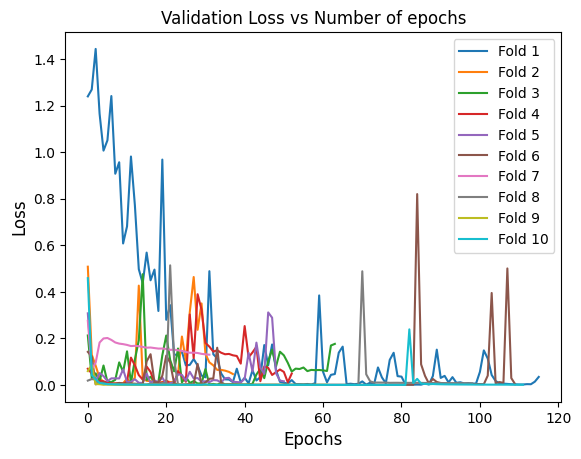

In [10]:

# Plot loss history
for i in range(len(history_by_fold)):
    plt.plot(history_by_fold[i].history["val_loss"], label = "Fold {}".format(i + 1))
plt.title("Validation Loss vs Number of epochs", fontsize = 12)
plt.xlabel("Epochs", fontsize = 12)
plt.ylabel("Loss", fontsize = 12)
plt.legend()
plt.show()


#### Show accuracy history by epochs.

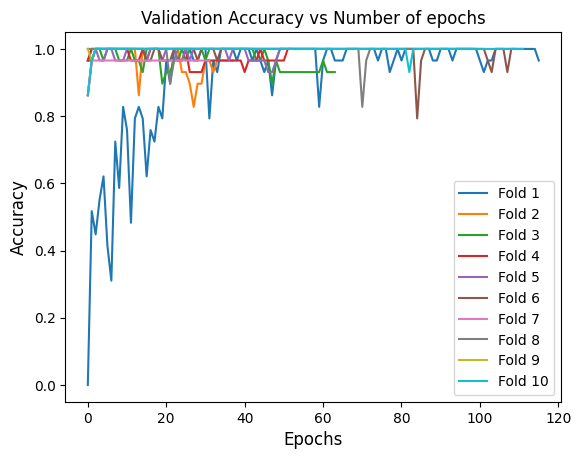

In [11]:

# Plot accuracy history
for i in range(len(history_by_fold)):
    plt.plot(history_by_fold[i].history["val_accuracy"], label = "Fold {}".format(i + 1))
plt.title("Validation Accuracy vs Number of epochs", fontsize = 12)
plt.xlabel('Epochs', fontsize = 12)
plt.ylabel('Accuracy', fontsize = 12)
plt.legend()
plt.show()
